In [1]:
%%capture --no-stderr
# %pip install -U langgraph langsmith langchain_anthropic --ignore-installed

In [2]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:

import os

ANTHROPIC_API_KEY = "ANTHROPIC_API_KEY"

os.environ["ANTHROPIC_API_KEY"] = ANTHROPIC_API_KEY

TAVILY_API_KEY = "TAVILY_API_KEY"

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [4]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class InputState(TypedDict):
    user_input: str

class OutputState(TypedDict):
    graph_output: str

class OverallState(TypedDict):
    foo: str
    user_input: str
    graph_output: str

class PrivateState(TypedDict):
    bar: str

def node_1(state: InputState) -> OverallState:
    # Write to OverallState
    return {"foo": state["user_input"] + " name"}

def node_2(state: OverallState) -> PrivateState:
    # Read from OverallState, write to PrivateState
    return {"bar": state["foo"] + " is"}

def node_3(state: PrivateState) -> OutputState:
    # Read from PrivateState, write to OutputState
    return {"graph_output": state["bar"] + " Lance"}

builder = StateGraph(OverallState,input=InputState,output=OutputState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

graph = builder.compile()
graph.invoke({"user_input":"My"})
{'graph_output': 'My name is Gilberto'}

{'graph_output': 'My name is Gilberto'}

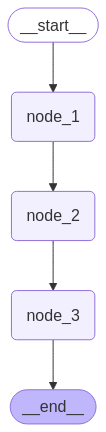

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass

In [29]:
config = {"configurable":{"thread_id": "1"}}

user_input = "Hi there! My name is Gilberto."

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config=config,
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Gilberto.
================================== Ai Message ==================================

Hello Gilberto! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or discuss?


In [30]:
user_input = "Do you remember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config=config,
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

Of course! You told me your name is Gilberto. I always try to remember important details that people share with me. Is there anything else you'd like to talk about or any questions you have, Gilberto?


In [31]:
events = graph.stream(
    {"messages":[{"role": "user", "content": user_input}]},
    config={"configurable": {"thread_id": "2"}},
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

I apologize, but I don't have any prior information about you or your name. As an AI assistant, I don't maintain personal memories or information about individual users across conversations. Each interaction starts fresh. Is there something specific you'd like assistance with? I'd be happy to help with any questions or tasks you might have.
